In [18]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)
df_tgt_ct = df_tgt_ct.drop('ds',axis=1).resample('M').mean()
df_tgt_ct = df_tgt_ct[df_tgt_ct.index<'2022-01-01']

In [23]:
fraction = 0.8
y_train = df_tgt_ct.iloc[:int(len(df_tgt_ct)*fraction)]
y_val = df_tgt_ct.iloc[int(len(df_tgt_ct)*fraction):]

In [24]:
model = pm.auto_arima(y_train.y, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,
                      d=1,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=False, 
                      stepwise=False)


 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=629.789, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=631.785, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=631.787, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=630.200, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=611.776, Time=0.72 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=631.785, Time=0.23 sec


In [25]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -299.888
Date:                Sat, 21 May 2022   AIC                            611.776
Time:                        17:31:39   BIC                            624.914
Sample:                             0   HQIC                           616.968
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2250      0.065     -3.466      0.001      -0.352      -0.098
ar.L1          1.4485      0.086     16.940      0.000       1.281       1.616
ar.L2         -0.6703      0.061    -10.973      0.0

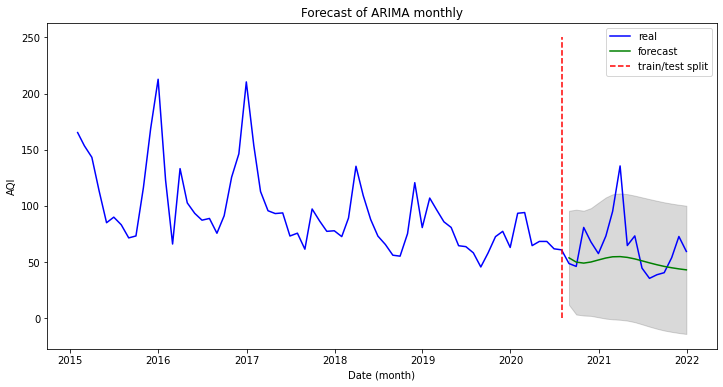

In [65]:
y = df_tgt_ct.y
n_periods = len(y_val)
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = y_val.index

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
fig = plt.figure(figsize=(12,6))
plt.plot(y,color = 'blue',label='real')
plt.plot(fc_series, color='green',label='forecast')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.vlines(y_train.index[len(y_train)-1],0,250, colors = "r", linestyles = "dashed",label='train/test split')
plt.xlabel('Date (month)')
plt.ylabel(target)
plt.legend()
plt.title("Forecast of ARIMA monthly")
plt.savefig('../time_series/pic/month/arima_month.png',facecolor='w')

In [60]:
res = pd.read_csv('../time_series/pic/month/summary.csv',index_col=0)
from metrics import calc_metric
res = res.append(calc_metric(y_val,fc_series,'ARIMA (monthly)'))
res.to_csv('../time_series/pic/month/summary.csv')


<Figure size 432x288 with 0 Axes>

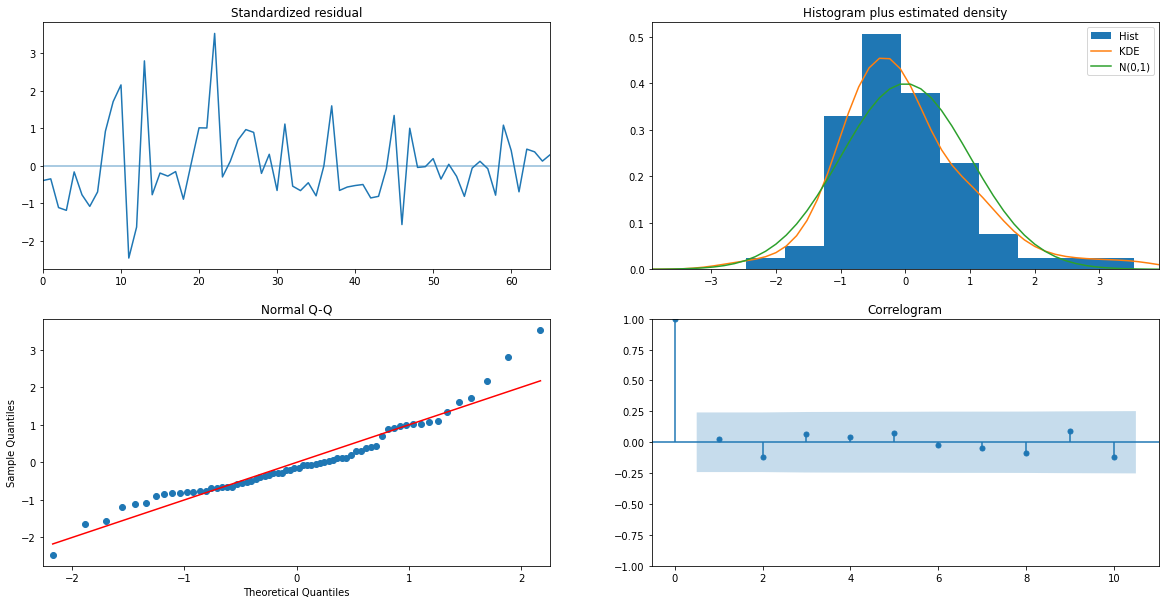

In [81]:
%matplotlib inline
plt.figure(facecolor='w')
model.plot_diagnostics(figsize=(20,10))
plt.savefig('../time_series/pic/month/arima_error.png')
plt.show()